# Table of Contents

* [IBM churn data](#IBM-churn-data)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Model fitting](#Model-fitting)
    * [Cross-Validation of out-of-the-box models](#Cross-Validation-of-out-of-the-box-models)
    * [Randomized Search CV for Random Forest](#Randomized-Search-CV-for-Random-Forest)
    * [Tuning XBGregression](#Tuning-XBGregression)
    * [Neural Networks Classification of Clients](#Neural-Networks-Classification-of-Clients)
* [Business returns of the analysis](#Business-returns-of-the-analysis)
* [Useful links](#Useful-links)

# IBM churn data


The main goal of this notebook is to present an example of churn analysis using Machine Learning algorithms. Churn analysis,
also referred to as customer attrition rate analysis, is the
evaluation of a company’s customer loss rate in order to reduce it. A high churn rate forces a company have more
expenses to bringing enough new customers to substitute the ones that leave. Even seemingly small, tiny
increases in churn rate can quickly have a major negative effect on your company’s ability to grow. Moreover,
high churn rates are more likely to compound over time.


 The data here analyzed was
generated by IBM and is available at [IBM Telco web page](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113).
The Telco customer churn data contains information about a telecommunications company that provided home phone and Internet
services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their
service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score,
and Customer Lifetime Value index.


To analyze the data, we will present first an
exploratory data analysis (EDA), then we will use some out-of-the-box results, follow by the use of pipelines to improve
the estimation, and end with recommendations of how to reduce the churn.


In particular, this notebook presents
* <b>EDA</b>: Exploratory Data Analysis to understand the problem.
* <b>Pipeline and Cross validation fitting</b>: We compare the results of an out-of-the-box fitting of the models:
    * <b>Logistic regression</b>
    * <b>Support Vector Machine</b>
    * <b>Random Forest</b>
    * <b>XGBoost</b>
* <b>Random Search</b>: we further explore the `random forest` and `XGBoost` models, using a `random search` for their
parameters
* <b>Neural Networks with Cross-Validation</b>: We further compare the results of the models against a `neural network`.
* <b>Recomendations to reduce the churn<b>


**The Docker image for this notebook could be downloaded from** [here](https://github.com/ArrigoCoen/Insurance_expenses_prediction/tree/main/Docker).

# <center> <img src="https://www.franklinapprenticeships.com/wp-content/uploads/2020/10/IBM_logoR_blue60_RGB-scaled.jpg" alt="drawing" width="500"/> <center>

In [1]:

# General computation modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import datetime

import statsmodels
import os

# Data transformation modules
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector     # new in 0.22

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Machine Learning modules
from sklearn.pipeline import make_pipeline, Pipeline

# Neural Networks modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor



from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from keras.wrappers.scikit_learn import KerasClassifier

# Possible useful modules
# from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
# from sklearn.model_selection import cross_val_score

from Project_Functions import *

## Exploratory Data Analysis

In order predict the churn of a client we have the following features to train our models:

* <b> customerID</b>: id of key of each customer compose of 4 numbers and five letters (eg. 7590-VHVEG).
* <b> gender</b>: gender of customer (Female/Male).
* <b> SeniorCitizen</b>: boolean variable about the citizen status of the cliet (0/1).
* <b> Partner</b>: partner status (integer).
* <b> Dependents</b>: number of dependents (integer).
* <b> tenure</b>: tenure number (integer).
* <b> PhoneService</b>: phone service status (Yes/No).
* <b> MultipleLines</b>: multiple lines status (Yes/No /No phone service).
* <b> InternetService</b>: internet service status (Fiber optic/DSL/No).
* <b> OnlineSecurity</b>: online security status (Yes/No/No internet service).
* <b> OnlineBackup</b>: online backup status (Yes/No/No internet service).
* <b> DeviceProtection</b>: device protection status (Yes/No/No internet service).
* <b> TechSupport</b>: tech support status (Yes/No/No internet service).
* <b> StreamingTV</b>: streaming TV status (Yes/No/No internet service).
* <b> StreamingMovies</b>: streaming movies status (Yes/No/No internet service).
* <b> Contract</b>: contract status (Month-to-month/Two year/One year).
* <b> PaperlessBilling</b>: paperless billing status (Yes/No).
* <b> PaymentMethod</b>: payment method status (Electronic check/Mailed check/Bank transfer (automatic)/Credit card (automatic)).
* <b> MonthlyCharges</b>: montly charges (numeric).
* <b> TotalCharges</b>: total charges (string).
* <b> Churn</b>: churn status (Yes/No).

To have a general idea of each feature, let us see the first five rows of information.

In [2]:
df = pd.read_csv("input/Telco-Customer-Churn.csv")
print("The umber of rows is",len(df)," and number of columns is", len(df.columns))
df.head()

The umber of rows is 7043  and number of columns is 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


To continue with the analysis, let us see if there are missing values.

In [3]:
print("------------------------\nMissing values\n------------------------")
print(df.isnull().sum())
print("\n------------------------\nColumns types\n------------------------")
print(df.info())

------------------------
Missing values
------------------------
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

------------------------
Columns types
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   D

At a first glance, it seems that we do not have any missing value, but if we look closer to the column`TotalCharges` we could notice
that is a string column instead of being a numeric column. In the next cell, we found how many empty values appear
in `TotalCharges`.

In [4]:
# Index of missing values of column TotalChanges
df[df['TotalCharges']==" "].index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

There are 11 missing values of `TotalCharges`. Since they are so few missing observation (compare to the number of total rows 7043)
we will erase these rows. In cases with more missing values, we could
need to add a feature like `emptyTotalCharges` to let our model learn about this condition. In this case we do not have
enough information to train a model with respect to the missing values pattern. The next cell erases the 11 rows with
missing values and change the remain values of `TotalCharges` to a numeric type.

In [5]:
# Drop the row with empty TotalCharges
ind=df[df['TotalCharges']==" "].index
df = df.drop(index=ind)
# Change datatype of column TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')

To further explore the data, in the next cell we show the general information of each column. In particular, we display
the column type; this will be very important to define each feature
transformation that so we could not have any data-leakage problems when we perform cross-validation.

column =  customerID
object
7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: customerID, Length: 7032, dtype: int64
column =  gender
object
Male      3549
Female    3483
Name: gender, dtype: int64


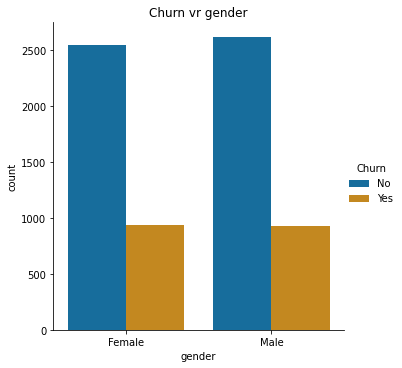

column =  SeniorCitizen
int64
count    7032.000000
mean        0.162400
std         0.368844
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64


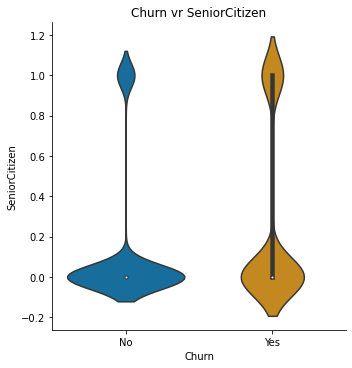

column =  Partner
object
No     3639
Yes    3393
Name: Partner, dtype: int64


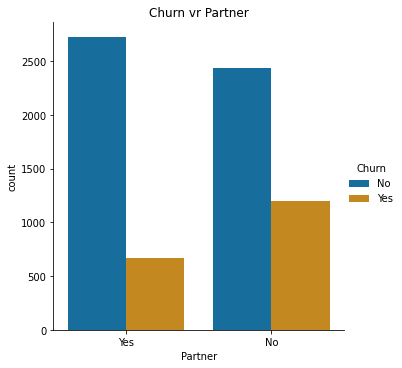

column =  Dependents
object
No     4933
Yes    2099
Name: Dependents, dtype: int64


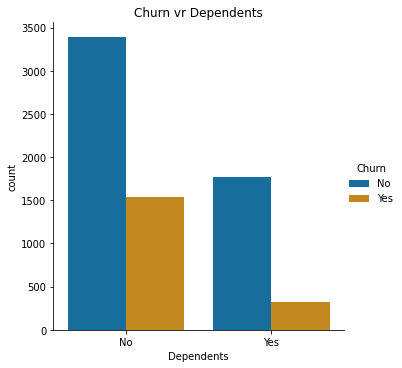

column =  tenure
int64
count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


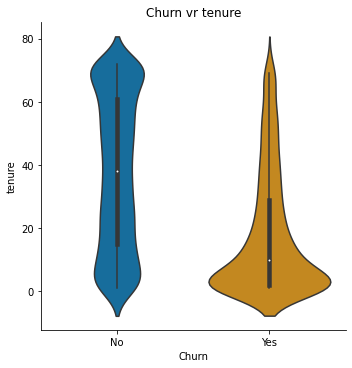

column =  PhoneService
object
Yes    6352
No      680
Name: PhoneService, dtype: int64


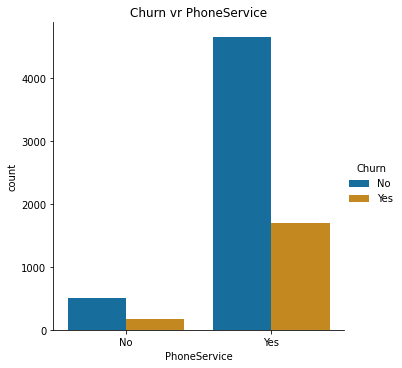

column =  MultipleLines
object
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64


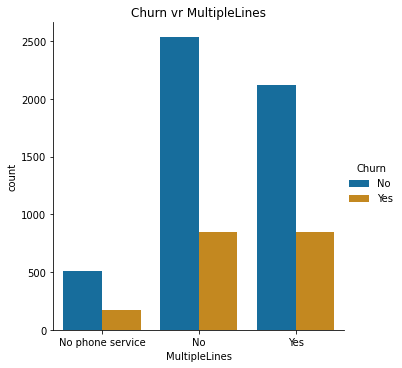

column =  InternetService
object
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64


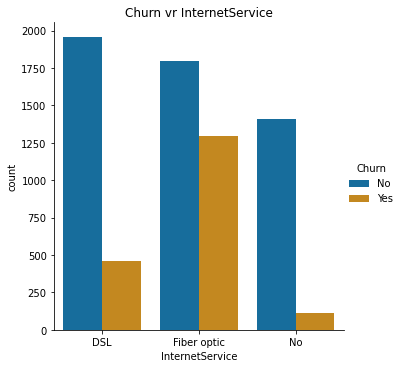

column =  OnlineSecurity
object
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64


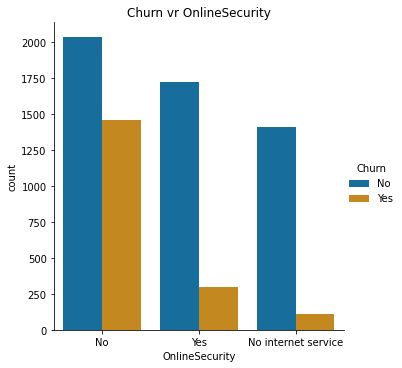

column =  OnlineBackup
object
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64


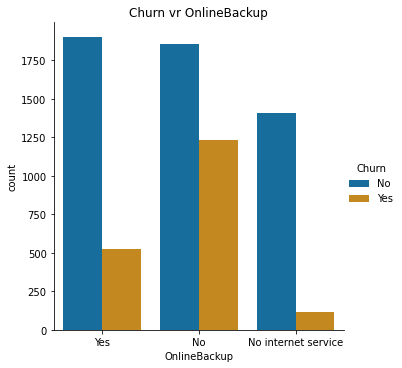

column =  DeviceProtection
object
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64


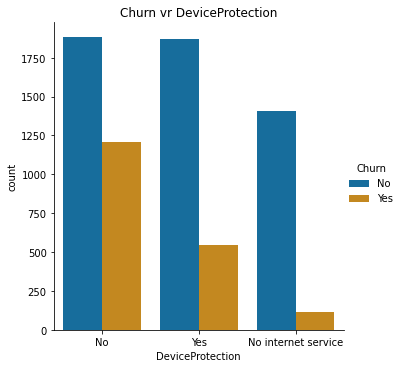

column =  TechSupport
object
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64


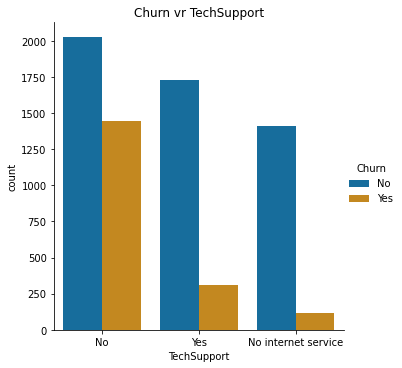

column =  StreamingTV
object
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64


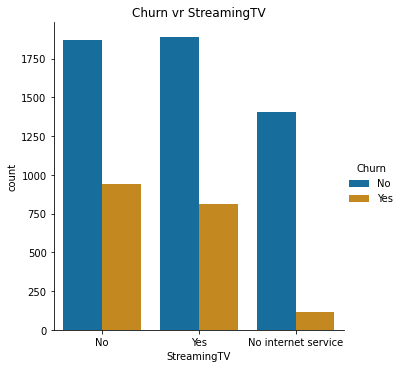

column =  StreamingMovies
object
No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64


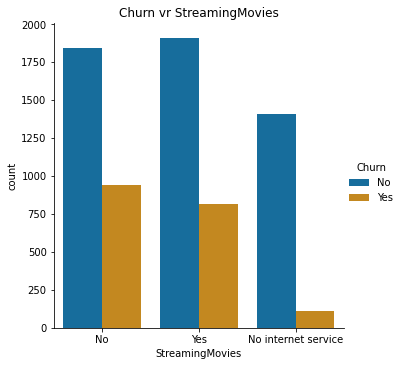

column =  Contract
object
Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64


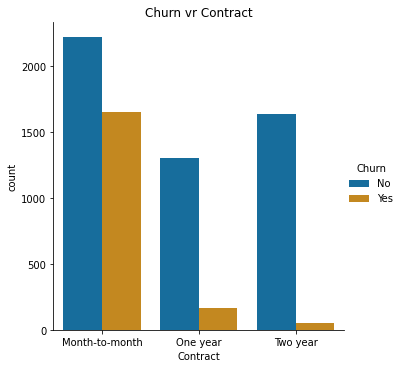

column =  PaperlessBilling
object
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64


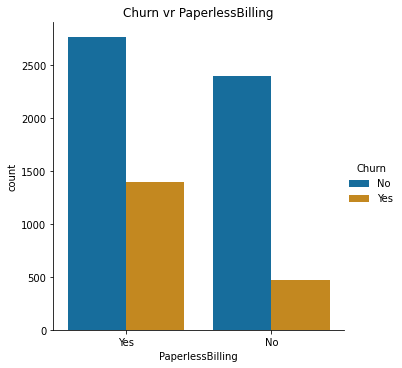

column =  PaymentMethod
object
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64


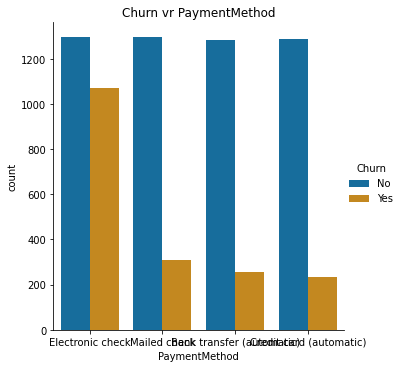

column =  MonthlyCharges
float64
count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64


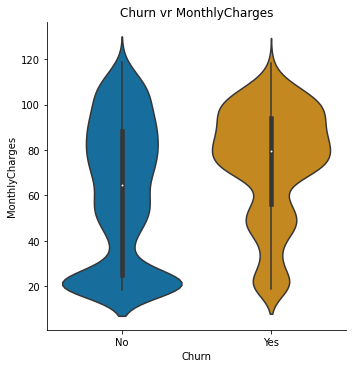

column =  TotalCharges
float64
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


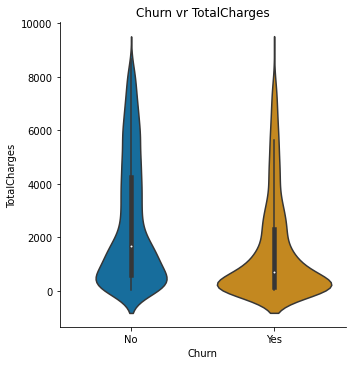

column =  Churn
object
No     5163
Yes    1869
Name: Churn, dtype: int64


True

In [6]:
target_name = 'Churn'
not_to_plot = ['customerID']
col_vr_target(df, target_name, not_to_plot)

We notice that:
 - There are multiple features that are correlated with churn.
 - We need to drop `customerID`.
 - `SeniorCitizen` is already display as a boolean variable not as a Yes/No variable.
 - Maybe we could join `PhoneService` and `MultipleLines` since this last column has as values 'Yes'/'No'/'No phone service'.

In the next cell we have the pairplot of the numeric variables.

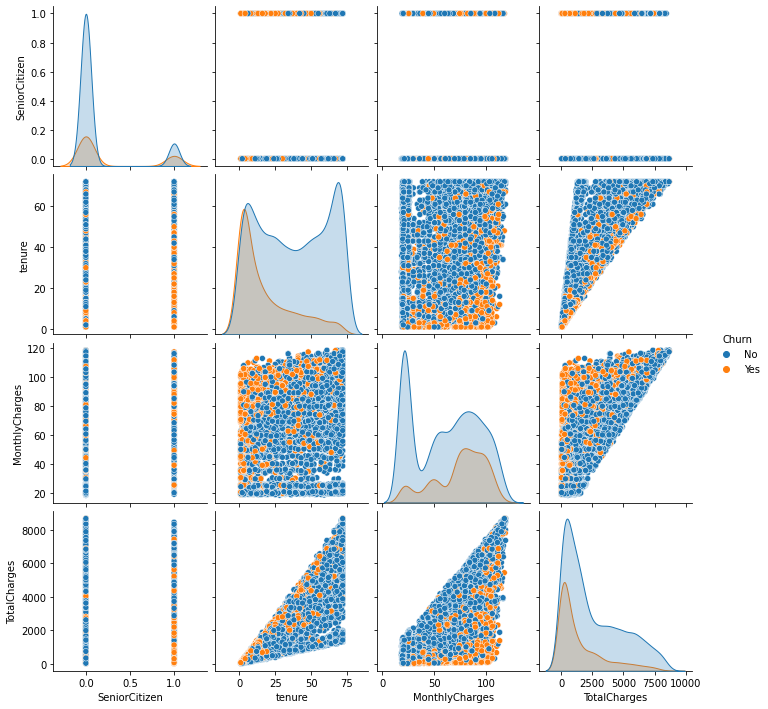

In [7]:
# Grouping variable that will produce elements with different colors.
sns.pairplot(hue=target_name, data=df.drop('customerID', axis=1))
plt.show()

The pairplot shows the different behaviours of clients with respect to the variable `Churn`.
For instance, clients with smaller `MonthtlyCharges` are more prompt to leave the company. On the opposite end, client with
higher tenure are less common to leave. The synergy between two or more features are also important to consider; for instance,
is important to consider how is affected the churn if a client is a senior citizen and has small total charges.

## Model fitting

In this section we will present the results of different Machine Learning models that we fit to the data. We will
compare how well each model is learning the paters using the accuracy and F1 measures. Also, we will compare the confusion
matrix of each model resultl.

To define a baseline of predictions, let us now continue with some out-of-the-box model fitting. In particular, we will fit the
models `LogisticRegression`, `Support Vector Machine (SVC)`, `RandomForestClassifier`, and `XGBClassifier`. Moreover, we will
use a cross-validation scheme to compare how well our models discover the patterns on the data.

Accordingly, let us separate the data into features (`X`) and target (`y`), followed by splitting it on train and test sets.

In [8]:
# Separating features and target variable
X = df.drop([target_name, 'customerID'], axis=1)
y =  df[target_name].replace(to_replace=['No', 'Yes'], value=[int(0), int(1)])
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

To have a common treatment on our cross-validation routines, we define in the next cell our column transformer that we
will use in the cross-validation tests. This transformer transforms the categorical variables using one-hot-encoder and
scales the numerical ones.

Moreover, since we do not have any missing values, we do not need to do any imputation. We use the
`make_column_transformer` routine since we are going to use pipelines and cross-validation.

In [28]:
column_trans = make_column_transformer(
    (OneHotEncoder(), make_column_selector(dtype_include='object')),
    (StandardScaler(), make_column_selector(dtype_exclude='object')),
    remainder='passthrough')

In the next section we will apply this column transformer to compare the models under a cross-validation scheme.

## Cross-Validation of out-of-the-box models

To apply cross-validation methodology without the jeopardy of data leakage, or other data manipulation problems, we
create the function `model_results`.
This function takes care of applying a 5-fold cross-validation to the model that it receives as an input and save the mean
and standard deviation of the errors of the folds in the dataframe `df_results`. Moreover, this function displays the
confusion matrix of fitting the model to all the train data (using `X_train` and `y_train`) and test it against the test data
(using `X_test` and `y_test` vr `y_pred`).

Also, we create function `normalized_bar_plot` displays a bar plot of the models cross-validation errors; is important
to notice that we normalize the values of the errors since they are in different magnitudes. This bar plot shows which
model has a better fit to the data in comparison to the other models.

Both of this functions are save in the `Project_Functions.py` that could be found [here](https://github.com/ArrigoCoen/IBM_Churn/blob/main/Functions/Project_Functions.py).

LogisticRegression
The file  Pickles/Model_LogisticRegression.pkl was save.


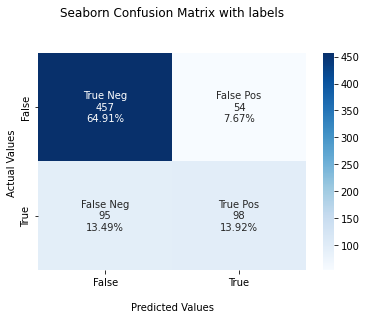

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       511
           1       0.64      0.51      0.57       193

    accuracy                           0.79       704
   macro avg       0.74      0.70      0.71       704
weighted avg       0.78      0.79      0.78       704

SVC
The file  Pickles/Model_SVC.pkl was save.


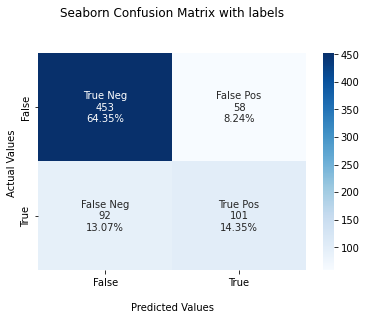

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       511
           1       0.64      0.52      0.57       193

    accuracy                           0.79       704
   macro avg       0.73      0.70      0.72       704
weighted avg       0.78      0.79      0.78       704

RandomForestClassifier
The file  Pickles/Model_RandomForestClassifier.pkl was save.


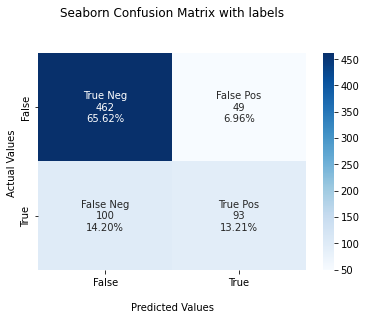

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       511
           1       0.65      0.48      0.56       193

    accuracy                           0.79       704
   macro avg       0.74      0.69      0.71       704
weighted avg       0.78      0.79      0.78       704

XGBClassifier


/Users/arrigocoen/Dropbox/GitHub/2021 Repos/RNN/Enviroments/Python3_9_Mac/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/arrigocoen/Dropbox/GitHub/2021 Repos/RNN/Enviroments/Python3_9_Mac/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_depr

[18:41:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The file  Pickles/Model_XGBClassifier.pkl was save.


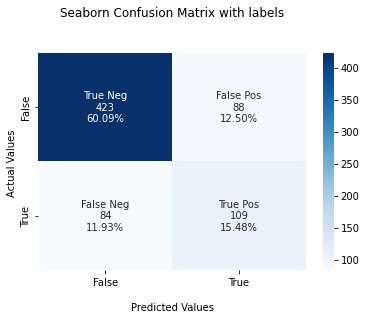

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       511
           1       0.55      0.56      0.56       193

    accuracy                           0.76       704
   macro avg       0.69      0.70      0.70       704
weighted avg       0.76      0.76      0.76       704



,model,accuracy_mean,accuracy_std,f1_mean,f1_std
0,LogisticRegression,0.806259,0.011562,0.800406,0.011524
1,SVC,0.801203,0.011203,0.794935,0.011503
2,RandomForestClassifier,0.787613,0.011090,0.777661,0.011111
3,XGBClassifier,0.769598,0.013461,0.772952,0.012234


In [10]:
# the estimate variable prevents some errors of XGBClassifier
my_verbose = 0
estimate=df['Churn'].value_counts()[0]/df['Churn'].value_counts()[1]

models = [LogisticRegression(max_iter=200),
          SVC(kernel='linear'),
          RandomForestClassifier(n_estimators=200),
          XGBClassifier(n_estimators=200, scale_pos_weight=estimate)]

# We save the results of the cross-validation in results_df
col_results = ['model', 'accuracy_mean', 'accuracy_std', 'f1_mean', 'f1_std']
results_df = pd.DataFrame(np.zeros([1,len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    results_df = model_results(model, results_df, column_trans,
                               X_train, X_test, y_train, y_test, None, 0)

results_df

We could notice that:
 - The `RandomForestClassifier` and `XGBClassifier` report the smallest errors with respect to accuracy and F1 measures.
 - The standard deviation of all the models is relatively similar, but slightly smaller on `Logistic Regression` and `SVC`.
 - A further exploration of these tree models could improve the results.
 - We could use the tree models to compare the impact of each feature on the churn.

Let us now compare graphically these errors.

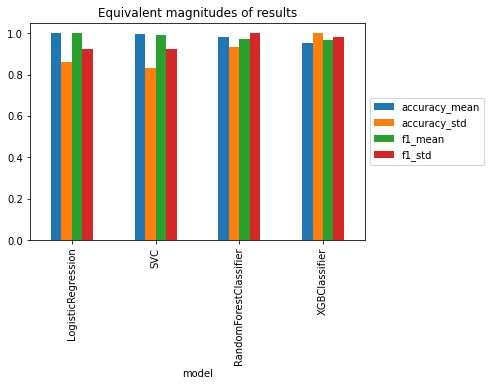

In [69]:
normalized_bar_plot(results_df)

Let us plot an scaled version of the `results_df` to compare graphically the models. For scaled version we mean that we
divide each value between the maximum value, to scale each of the numeric columns of `results_df`.

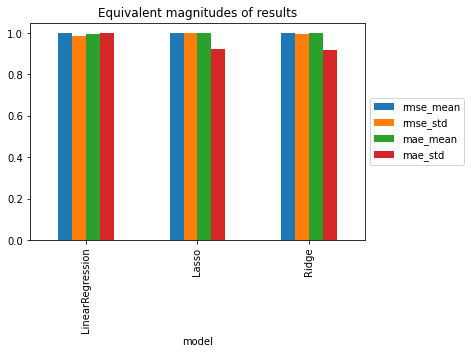

In [23]:
normalized_bar_plot(results_df)

We can see that the best out-of-the-box models were the `RandomForestClassifier()` and `XGBClassifier()`. Accordingly, in
the next sections we will fine tune these two models using `GridSearchCV` to find their parameters and `Pipeline` to
control the workflow.

# Randomized Search CV for Random Forest

In this section we will use `RandomSearchCV` to tune the `RandomForestClassifier()` to improve its accuracy.

In [11]:
# General model template
model_1 = RandomForestClassifier()

# Create the Pipeline
pipe = Pipeline([('preprocessor', column_trans), ('model', model_1)])

# Model parameters
params1 = {}
params1['model__bootstrap'] = [True, False]
params1['model__max_depth'] = [70, 80, 90, 100, 110]
params1['model__max_features'] = [2, 3, 4, 6, 10]
params1['model__min_samples_leaf'] = [2, 3, 4, 5, 6]
params1['model__min_samples_split'] = [5, 8, 10, 12]
params1['model__n_estimators'] = [100, 150, 200, 500, 1000]
params1['model'] = [model_1]

params = [params1]

# In case of having more that one model define: # params = [params1, params2]
grid_RF = RandomizedSearchCV(pipe, params, n_jobs=-1, n_iter=15, verbose=10, cv=3, scoring='accuracy',
                             random_state = 42)
grid_RF.fit(X_train, y_train)
grid_RF.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'model__n_estimators': 200,
 'model__min_samples_split': 8,
 'model__min_samples_leaf': 5,
 'model__max_features': 6,
 'model__max_depth': 90,
 'model__bootstrap': False,
 'model': RandomForestClassifier(bootstrap=False, max_depth=90, max_features=6,
                        min_samples_leaf=5, min_samples_split=8,
                        n_estimators=200)}

RandomForestRegressor_Tuned
The file  Pickles/Model_RandomForestRegressor_Tuned.pkl was save.


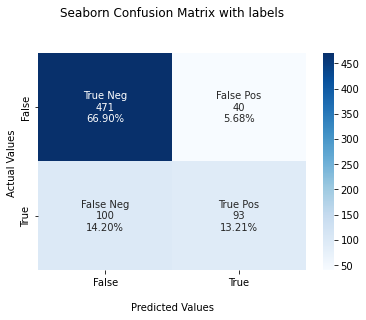

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       511
           1       0.70      0.48      0.57       193

    accuracy                           0.80       704
   macro avg       0.76      0.70      0.72       704
weighted avg       0.79      0.80      0.79       704



,model,accuracy_mean,accuracy_std,f1_mean,f1_std
0,LogisticRegression,0.806259,0.011562,0.800406,0.011524
1,SVC,0.801203,0.011203,0.794935,0.011503
2,RandomForestClassifier,0.787613,0.011090,0.777661,0.011111
3,XGBClassifier,0.769598,0.013461,0.772952,0.012234
4,RandomForestRegressor_Tuned,0.803889,0.008698,0.794834,0.008552


In [12]:
model = grid_RF.best_params_['model']
# results_df = model_results(model, results_df, model_name = 'RandomForestRegressor_Tuned')
results_df = model_results(model, results_df, column_trans,
                               X_train, X_test, y_train, y_test, 'RandomForestRegressor_Tuned', 0)


results_df

We notice an improvement of the random forest model after tuning it. So, it continues being our best model.

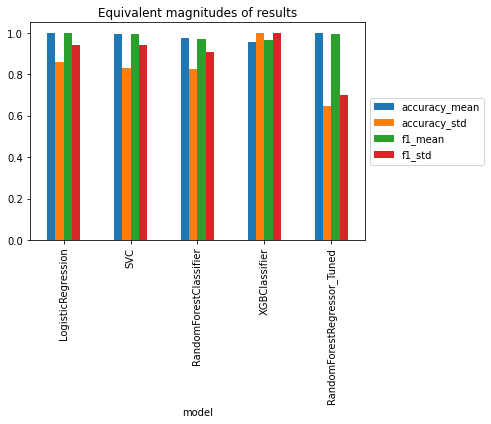

In [13]:
normalized_bar_plot(results_df)


## Random Forest Feature importance

In this section we will use our random forest model that we tune, to find the feature importance.

standardscaler__tenure                                    0.138089
standardscaler__TotalCharges                              0.127833
onehotencoder__Contract_Month-to-month                    0.124379
standardscaler__MonthlyCharges                            0.087305
onehotencoder__OnlineSecurity_No                          0.055895
onehotencoder__TechSupport_No                             0.049456
onehotencoder__InternetService_Fiber optic                0.045350
onehotencoder__Contract_Two year                          0.033175
onehotencoder__PaymentMethod_Electronic check             0.029550
onehotencoder__InternetService_DSL                        0.020942
onehotencoder__OnlineBackup_No                            0.018188
onehotencoder__Contract_One year                          0.017654
onehotencoder__OnlineSecurity_Yes                         0.016895
onehotencoder__DeviceProtection_No                        0.012554
onehotencoder__TechSupport_Yes                            0.01

True

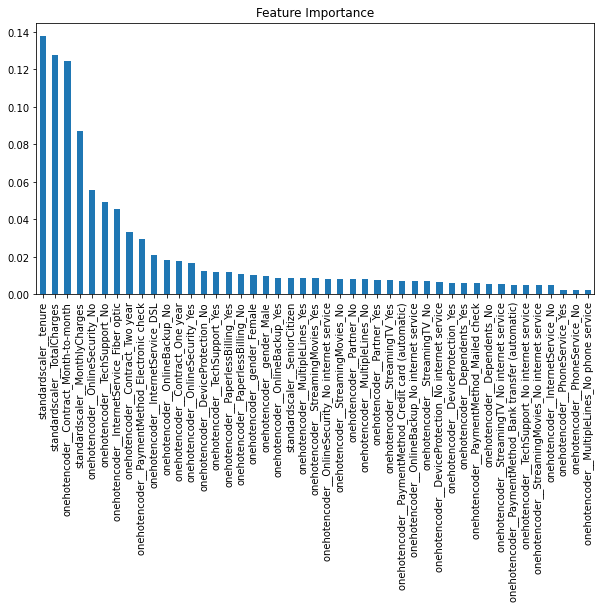

In [73]:
model = grid_RF.best_params_['model']
name_fig = 'Bar_plot_RF_feature_importance'
my_save_figure_feature_imortance(model, column_trans, X_train, name_fig)

## Tuning XBGregression

In [140]:
from xgboost import XGBClassifier
# Start
model_1 = XGBClassifier()

# create the Pipeline
pipe = Pipeline([('preprocessor', column_trans), ('model', model_1)])

my_n_estimators = 1000

params1 = {}
# params1['model__gamma'] = [0]
params1['model__eta'] = [0.4, 0.3, 0.1, 0.01]
params1['model__max_depth'] = [1, 2, 3, 4]
params1['model__n_estimators'] = [my_n_estimators]
params1['model__subsample'] = sp.stats.uniform(scale=1)
params1['model__colsample_bytree'] = sp.stats.uniform(scale=1)

params1['model'] = [model_1]

grid_XGB = RandomizedSearchCV(pipe, params1, n_jobs=-1, n_iter=20, verbose=1, cv=3, random_state = 42)

# print(grid)
grid_XGB.fit(X_train, y_train)
grid_XGB.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/arrigocoen/Dropbox/GitHub/2021 Repos/RNN/Enviroments/Python3_9_Mac/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/arrigocoen/Dropbox/GitHub/2021 Repos/RNN/Enviroments/Python3_9_Mac/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_depr

KeyboardInterrupt: 

XGBRegressor_Tuned


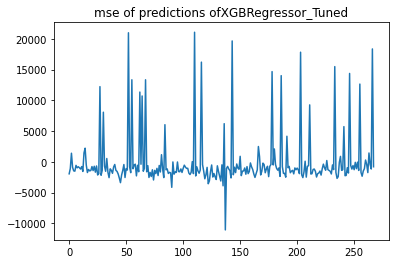

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6155.112802,4.956161e+06,64.995007,265.229978
1,Lasso,6146.783657,5.028188e+06,65.126862,244.462377
2,Ridge,6146.993987,5.004419e+06,65.168117,243.363537
3,RandomForestRegressor_Tuned,4606.962956,4.586996e+06,51.051526,152.480223
4,XGBRegressor_Tuned,4561.955219,4.740726e+06,50.765572,154.377911


In [28]:
model = grid_XGB.best_params_['model']

results_df = model_results(model, results_df, model_name = 'XGBRegressor_Tuned')
results_df

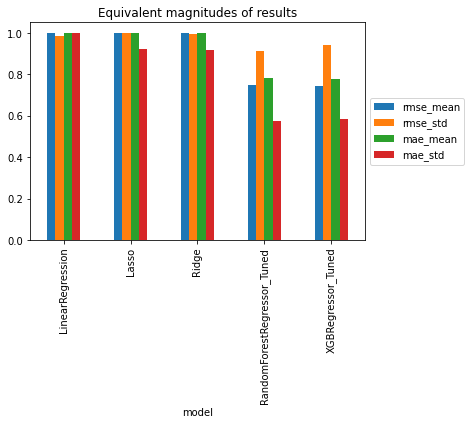

In [29]:
normalized_bar_plot(results_df)

After tuning the XGBoost model we get an improvement on the MSE in comparison to the Random Forest model tuned. So, our
current best model is the `XGBRegressor_Tuned`.

# Neural Networks Classification of Clients

Now, let us change gears a little and consider a Neural Network model to predict the charges. After doing some testing,
we found that we do not need a very deep network neither its layes need to have many neurons. We use a five layer with
a first layer of 128 neurons and the others of 64. Since we have a regression problem we define a final layers of one
neuron. Also, our test show that the activation `relu` was good enough and that no dropout layers were needed.

As a loss function we choose the MSE, and we found that 80 epochs were enough to not overfit. We recommend changing the
`verbose` parameter of `model.fit` to get more information about the fitting of the network to the train and test sets.

In [210]:


X_train_ct = column_trans.fit_transform(X_train)
X_train_ct

array([[ 0.        ,  1.        ,  0.        , ...,  0.47490363,
        -0.34767168,  0.01505646],
       [ 0.        ,  1.        ,  0.        , ...,  1.20679586,
        -1.34398772, -0.37711325],
       [ 1.        ,  0.        ,  0.        , ..., -0.90755947,
        -1.4915287 , -0.91663771],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.94822015,
         0.54254747, -0.6583989 ],
       [ 1.        ,  0.        ,  1.        , ...,  0.7188677 ,
        -1.49318646, -0.56849646],
       [ 0.        ,  1.        ,  0.        , ..., -0.50095268,
         0.29388291, -0.36002036]])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               5888      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 18,369
Trainable params: 18,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5695/5695 [==============================] - 13s 2ms/step - loss: 0.4477 - accuracy: 0.7817 - val_loss: 0

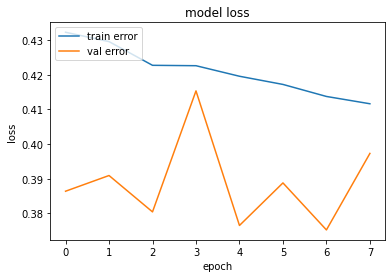

In [80]:
# column_trans_NN = make_column_transformer(
#     (OneHotEncoder(), ['sex', 'smoker', 'region']),
#     (StandardScaler(), ['age', 'bmi', 'children']),
#     remainder='passthrough')


import tensorflow as tf

X_train_ct = column_trans.fit_transform(X_train)
X_test_ct = column_trans.transform(X_test)

model = Sequential()
model.add(Dense(128, input_dim=len(column_trans.fit_transform(X_train)[0]),  activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss= 'binary_crossentropy' ,metrics=['accuracy'], optimizer='adam')

model.summary()
# create the Pipeline

# pipe = make_pipeline(column_trans,StandardScaler(), model)
history = model.fit(X_train_ct, y_train, epochs = 10, validation_split = 0.1, batch_size=1, verbose = 1)
y_pred = model.predict(X_test_ct)



skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train error', 'val error'], loc='upper left')
plt.show()

In [81]:
my_piclke_dump(model, 'Model_Neural_Network')


TypeError: cannot pickle 'weakref' object

In [88]:




print(type(model))
model_name = 'Neural_Network'




save_NN_sequential(model, model_name)


<class 'keras.engine.sequential.Sequential'>
The file  Pickles/Model_Neural_Network.h5 was save.


True

In [118]:
modulereload(Project_Functions)
from Project_Functions import *

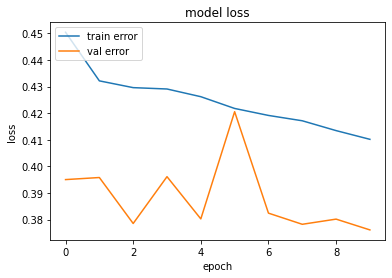

In [72]:
skip_to_plot = 0
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train error', 'val error'], loc='upper left')
plt.show()

An important element of our network is the dropout layer. It helps us to not overfit as could be seen in the graph of
the train vr test error. We perform test without it and the network memorizes the data. This is something that we could
expect since we do not have many data instances.

To use our pipeline we define the function create_network to wrap our neural network model in to a proper input for
the cross-validation rutine that we have.

In [31]:
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)


In [122]:

# Create function returning a compiled network
def create_network():
    model = Sequential()
    model.add(Dense(128, input_dim=len(column_trans.fit_transform(X_train)[0]), activation='relu'))
    model.add(Dropout(0.10))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss= 'binary_crossentropy' ,metrics=['accuracy'], optimizer='adam')

    # Return compiled network
    return model
# evaluate model
model = KerasClassifier(build_fn=create_network, epochs=10, batch_size=500, verbose=0)


Sequential


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


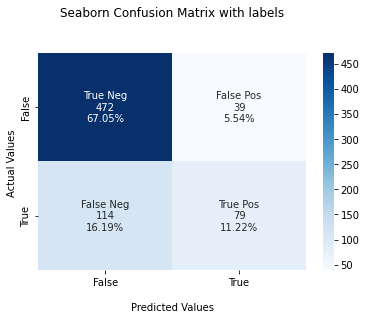

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       511
           1       0.67      0.41      0.51       193

    accuracy                           0.78       704
   macro avg       0.74      0.67      0.68       704
weighted avg       0.77      0.78      0.76       704



,model,accuracy_mean,accuracy_std,f1_mean,f1_std
0,LogisticRegression,0.806259,0.011562,0.800406,0.011524
1,SVC,0.801203,0.011203,0.794935,0.011503
2,RandomForestClassifier,0.791722,0.011012,0.781903,0.011021
3,XGBClassifier,0.769598,0.013461,0.772952,0.012234
4,Sequential,0.800887,0.009326,0.794712,0.011674


In [123]:
results_df = model_results(model, results_df, column_trans,
                               X_train, X_test, y_train, y_test, 'Neural Network', 3, True)

# results_df = model_results(model, results_df, model_name = 'Sequential',verbose=3)
results_df

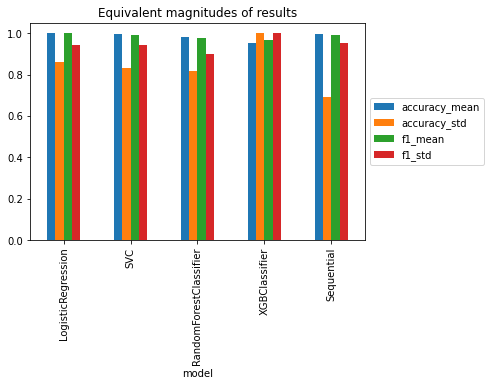

In [124]:

normalized_bar_plot(results_df)

The last plot shows that we almost get as small errors with the neural network as the ones with the other models.
Nevertheless, we have a remarkably bigger variance in the MAE CV errors and also the computational time was much bigger
that the ones of the other models.

## Business returns of the analysis

The main return of the analysis here presente is to decrease the error on the price of new insurance policies. By decreasing this error, not only the company increase its earnings but also the customer could afoard policies with more benefits. 

Also this analysis helps to better cluster the customer into different types. To have a better idea of the customer niche will save inecesary costs of not needed benefits and could set better thresholds to differentiate the customer characteristics.

As a summary of the analysis we could conclude:

- <b>An important factor is the smoking feature</b>: the charges are much bigger on people that smokes that on people
that don't. Using the weight of `linel regression` and `Random Forest` algorithms we could see that these two features
are very important.
- <b>Random Forest gives a good and fast fit</b>: the Random Forest algorithm give us the smallest errors in comparison
to other models. Moreover, the time to train this model was also small. This model has a good equilibrium between
accuracy and computational time for the data that we are analyzing.
- <b>A bigger data set could be useful to improve the analysis</b>: In this notebook we study a relative small data set to analyze the behavior
of the charges of the policyholders. More features or more examples could be useful to discover more particularities
of the population. With more data we could have an improvement on the company savings since a better calculation of the costs could represent
a more market competitive prices.




This type of analysis are useful for many companies to improve their customer experience to increase their retention. It
is less expensive to improve a current customer experience, than the investment on the search of new customers. Once the
 actual dropoff points of a churn are found, one can begin to pinpoint
why your clients leave. Of particular importance is to find the main variables than interact in customer retention.
Also this analysis helps to come up with hypotheses that can be verified via A/B tests or other methods.

Churn can be powered by a number of factors, and even small month-on-month increases in churn percentage can be ruinous
to planning, so understanding what churn is and how to analyze it is paramount.


## Useful links:

- Kaggle version the data [link](https://www.kaggle.com/blastchar/telco-customer-churn)
- IBM Telco data [link](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)
- Old
- Pipelines of scikit learn [link](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)
- Sequential models [link](https://www.codespeedy.com/the-sequential-model-in-keras-in-python/)
- Regression using Neural Networks [link](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
- Cross-validation of a network[link](https://chrisalbon.com/code/deep_learning/keras/k-fold_cross-validating_neural_networks/)
- Examples of regression [link](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
